In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import mpld3
import pydot
from IPython.display import SVG,clear_output, display
from pydrake.all import (
    AbstractValue,
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    JointSliders,
    LeafSystem,
    MeshcatVisualizer,
    Parser,
    RigidTransform,
    RollPitchYaw,
    AngleAxis,
    StartMeshcat,
    Simulator,
    BasicVector,
    AbstractValue,
    HalfSpace,
    CoulombFriction,
    ExpressionConstraint
    
)
from pydrake.multibody import inverse_kinematics

from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    AngleAxis,
    DiagramBuilder,
    Integrator,
    JacobianWrtVariable,
    LeafSystem,
    MeshcatVisualizer,
    MultibodyPlant,
    MultibodyPositionToGeometryPose,
    Parser,
    PiecewisePolynomial,
    PiecewisePose,
    Quaternion,
    Rgba,
    RigidTransform,
    RotationMatrix,
    SceneGraph,
    Simulator,
    StartMeshcat,
    TrajectorySource,
    MathematicalProgram
)
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    BsplineTrajectory,
    DiagramBuilder,
    KinematicTrajectoryOptimization,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    MinimumDistanceLowerBoundConstraint,
    Parser,
    PositionConstraint,
    OrientationConstraint,
    Rgba,
    RigidTransform,
    Role,
    Solve,
    Sphere,
    StartMeshcat,
    SpatialVelocityConstraint
)
from manipulation import ConfigureParser, running_as_notebook
from manipulation.scenarios import AddMultibodyTriad, AddShape
from manipulation.station import * 
# Start the visualizer.
meshcat = StartMeshcat()


INFO:drake:Meshcat listening for connections at https://51350a0a-d867-43ce-9cf7-7f2ad2ffd70b.deepnoteproject.com/7000/
Installing NginX server for MeshCat on Deepnote...


In [ ]:
def MakePickGripperFrames(W_X_Ginitial, W_X_B, G_X_Bgrasp):
    """
    Takes a partial specification with X_G["initial"] and X_O["initial"] and
    X_0["goal"], and returns a X_G and times with all of the pick and place
    frames populated.
    """
    Gripper_Frames = {}
    Gripper_Frames['initial'] = W_X_Ginitial
    print(W_X_Ginitial)

    # Define the gripper goal pose relative to the post pick pose.
    p_GgraspO = [0, -0.25, 0]
    Gpostpick_X_Ggoal = RigidTransform(p_GgraspO)

    B_X_Ggrasp = G_X_Bgrasp.inverse()


    # pregrasp is negative y in the gripper frame (see the figure!).
    Ggrasp_X_Gpregrasp = RigidTransform([0, -0.15, 0])

    Gripper_Frames["pick"] = W_X_B @ B_X_Ggrasp
    Gripper_Frames["prepick"] = Gripper_Frames["pick"] @ Ggrasp_X_Gpregrasp

    # Now let's set the timing
    times = {"initial": 0}
    Ginitial_X_Gprepick = Gripper_Frames["initial"].inverse() @ Gripper_Frames["prepick"]
    times["prepick"] = times["initial"] + 2.0 * np.linalg.norm(Ginitial_X_Gprepick.translation())
    # Allow some time for the gripper to close.
    times["pick_start"] = times["prepick"] + 1
    times["pick_end"] = times["pick_start"] + 1
    Gripper_Frames["pick_start"] = Gripper_Frames["pick"]
    Gripper_Frames["pick_end"] = Gripper_Frames["pick"]
    times["postpick"] = times["pick_end"] + 2.0
    Gripper_Frames["postpick"] = Gripper_Frames["prepick"]
    Gripper_Frames['goal'] = Gripper_Frames["postpick"] @ Gpostpick_X_Ggoal

    Ggoal_X_Gpreplace = Gripper_Frames["goal"].inverse() @ Gripper_Frames["postpick"]

    times["goal"] = times["postpick"] + 2.0 * np.linalg.norm( Ggoal_X_Gpreplace.translation())

    return Gripper_Frames, times


def MakeGripperPoseTrajectory(Gripper_Frames, times):
    """
    Constructs a gripper position trajectory from the plan "sketch".
    """

    sample_times = []
    poses = []
    for name in [
        "initial",
        "prepick",
        "pick_start",
        "pick_end",
        "postpick",
        "goal",
    ]:
        sample_times.append(times[name])
        poses.append(Gripper_Frames[name])

    return poses, sample_times

def MakeGripperCommandTrajectory(times):
    opened = np.array([0.107])
    closed = np.array([0.0])

    traj_wsg_command = PiecewisePolynomial.FirstOrderHold(
        [times["initial"], times["pick_start"]],
        np.hstack([[opened], [opened]]),
    )
    traj_wsg_command.AppendFirstOrderSegment(times["pick_end"], closed)
    return traj_wsg_command

def MakePickTrajectory(Gripper_Frames, times, q_start):
    q_prev = q_start

    joints = []
    gripper_frame = controller_plant.GetFrameByName("body", controller_plant.GetModelInstanceByName('gripper'))

    for pose in Gripper_Frames:
        ik = inverse_kinematics.InverseKinematics(controller_plant, controller_context)
        ik.AddPositionConstraint(
                frameA=controller_plant.world_frame(), frameB=gripper_frame, p_BQ=np.zeros(3),
                p_AQ_lower=pose.translation(), p_AQ_upper=pose.translation())
        ik.AddOrientationConstraint(
                frameAbar=controller_plant.world_frame(), R_AbarA=pose.rotation(),
                frameBbar=gripper_frame, R_BbarB=RotationMatrix(),
                theta_bound=0
            )

        ik.prog().AddCost(np.sum(((ik.q() - q_prev) * (ik.q() - q_prev))))
        MAX_ITERATIONS=5
        while MAX_ITERATIONS:
            ik.prog().SetInitialGuess(ik.q(), q_prev )
            ik_result = Solve(ik.prog())
            if ik_result.is_success(): 
                print("IK SUCCESSFUL")
                break
            print('ikbotch')
            print(ik_result.GetInfeasibleConstraints(ik.prog()))
            print(ik_result.GetInfeasibleConstraintNames(ik.prog()))
            print(ik_result.get_solution_result())
            MAX_ITERATIONS-=1
        q_prev = ik_result.GetSolution()
        joints.append(q_prev)
        del(ik)
        del(ik_result)
    print(len(joints))
    return PiecewisePolynomial.FirstOrderHold(
        times,
        np.array(joints).T,
    )
    

In [ ]:
APPROACH_TIME = 1
def MakeThrowTrajectory(W_p_Brelease, W_v_Brelease, W_X_Gstart, G_X_B, q_post_pick):
    W_v_Brelease = W_v_Brelease.flatten()
    W_p_Brelease = W_p_Brelease.flatten()
    
    y_axis = np.array([0,-1,0])
    new_y_axis = W_v_Brelease
    new_y_axis = new_y_axis/np.linalg.norm(new_y_axis)
    rot_axis = np.cross(y_axis, new_y_axis)
    if np.linalg.norm(rot_axis) == 0: rot_axis = [0,0,1]
    else: rot_axis = rot_axis/np.linalg.norm(rot_axis)
    angle = np.arccos(np.dot(y_axis, new_y_axis))
    # print(new_y_axis)


    rotation = AngleAxis(angle = angle, axis = rot_axis)

    W_X_GThrow = RigidTransform(p=W_p_Brelease,theta_lambda=rotation) @ G_X_B.inverse()

    dt = 0.01
    W_X_GPreThrow = RigidTransform(p=W_p_Brelease - dt*W_v_Brelease,theta_lambda=rotation) @ G_X_B.inverse()

    
    W_v_Gthrow = W_v_Brelease.reshape((3,1))

    return IKFromPose(W_X_GThrow,W_X_GPreThrow, W_v_Gthrow, W_X_Gstart, q_post_pick)

def MakeBatTrajectory(W_p_Bbat, W_v_Bbat, W_X_Gstart, G_X_B, q_post_pick):
    W_v_Bbat = W_v_Bbat.flatten()
    W_p_Bbat = W_p_Bbat.flatten()
    
    x_axis = np.array([-1,0,0])
    new_y_axis = W_v_Bbat
    new_y_axis = new_y_axis/np.linalg.norm(new_y_axis)
    rot_axis = np.cross(x_axis, new_y_axis)
    if np.linalg.norm(rot_axis) == 0: rot_axis = [0,0,1]
    else: rot_axis = rot_axis/np.linalg.norm(rot_axis)
    angle = np.arccos(np.dot(x_axis, new_y_axis))
    # print(new_y_axis)


    rotation = AngleAxis(angle = angle, axis = rot_axis)

    W_X_GThrow = RigidTransform(p=W_p_Bbat,theta_lambda=rotation) @ G_X_B.inverse()

    dt = 0.25
    W_X_GPreThrow = RigidTransform(p=W_p_Bbat - dt*W_v_Bbat,theta_lambda=rotation) @ G_X_B.inverse()

    
    W_v_Gthrow = W_v_Bbat.reshape((3,1))
    print(W_X_GThrow,W_X_GPreThrow, W_v_Gthrow, W_X_Gstart)

    return IKFromPose(W_X_GThrow,W_X_GPreThrow, W_v_Gthrow, W_X_Gstart, q_post_pick, False)

def IKFromPose(W_X_GThrow,W_X_GPreThrow, W_v_Gthrow, W_X_Gstart, q_post_pick, pitch=True):
    q0 = q_post_pick
    controller_plant.SetPositions(controller_context, q0)
    controller_plant_ad.SetPositions(controller_context_ad, q0)
    
    gripper_frame = controller_plant.GetFrameByName("body", controller_plant.GetModelInstanceByName('gripper'))
    # print(gripper_frame.CalcPoseInWorld(controller_context))

    tolerance = 0
    deg_tolerance = 0 * 2 * np.pi/180

    ik = inverse_kinematics.InverseKinematics(controller_plant, controller_context)
    ik.AddPositionConstraint(
            frameA=controller_plant.world_frame(), frameB=gripper_frame, p_BQ=np.zeros(3),
            p_AQ_lower=W_X_GThrow.translation() - tolerance, p_AQ_upper=W_X_GThrow.translation() + tolerance)
    ik.AddOrientationConstraint(
            frameAbar=controller_plant.world_frame(), R_AbarA=W_X_GThrow.rotation(),
            frameBbar=gripper_frame, R_BbarB=RotationMatrix(),
            theta_bound=deg_tolerance
        )

    ik.prog().AddCost(np.sum((( ik.q() - q0) * ( ik.q() - q0))))
    MAX_ITERATIONS=50
    while MAX_ITERATIONS:
        ik.prog().SetInitialGuess(ik.q(), q0 + np.random.rand(*ik.q().shape)*2 - 1)
        ik_result = Solve(ik.prog())
        if ik_result.is_success(): 
            print("IK SUCCESSFUL")
            break
        print('ikbotch')
        print(ik_result.GetInfeasibleConstraints(ik.prog()))
        print(ik_result.GetInfeasibleConstraintNames(ik.prog()))
        print(ik_result.get_solution_result())
        MAX_ITERATIONS-=1
    q_throw = ik_result.GetSolution()
    del(ik)
    del(ik_result)



    ik = inverse_kinematics.InverseKinematics(controller_plant, controller_context)
    ik.AddPositionConstraint(
            frameA=controller_plant.world_frame(), frameB=gripper_frame, p_BQ=np.zeros(3),
            p_AQ_lower=W_X_GPreThrow.translation() - tolerance, p_AQ_upper=W_X_GPreThrow.translation() + tolerance)
    ik.AddOrientationConstraint(
            frameAbar=controller_plant.world_frame(), R_AbarA=W_X_GPreThrow.rotation(),
            frameBbar=gripper_frame, R_BbarB=RotationMatrix(),
            theta_bound=deg_tolerance
        )

    ik.prog().AddCost(np.sum(((ik.q() - q_throw) * (ik.q() - q_throw))))
    MAX_ITERATIONS=50
    while MAX_ITERATIONS:
        ik.prog().SetInitialGuess(ik.q(), q_throw + np.random.rand(*ik.q().shape)/5 - 0.1)
        ik_result = Solve(ik.prog())
        if ik_result.is_success(): 
            print("IK SUCCESSFUL")
            break
        print('ikbotch')
        print(ik_result.GetInfeasibleConstraints(ik.prog()))
        print(ik_result.GetInfeasibleConstraintNames(ik.prog()))
        print(ik_result.get_solution_result())
        MAX_ITERATIONS-=1
    q_prethrow = ik_result.GetSolution()
    del(ik)
    del(ik_result)

    tolerance = 0.05
    deg_tolerance = 2 * 2 * np.pi/180
    print(q0)
    print(q_throw)
    print(q_prethrow)
    num_var = controller_plant.num_positions()
    initial = None
    def compute_trajectory():
        trajopt = KinematicTrajectoryOptimization(num_var, 10)
        prog = trajopt.get_mutable_prog()

        lower_vel_bounds = controller_plant.GetVelocityLowerLimits()
        upper_vel_bounds = controller_plant.GetVelocityUpperLimits()

        trajopt.AddVelocityBounds(lower_vel_bounds*5, upper_vel_bounds*5)

        trajopt.AddPositionBounds(controller_plant.GetPositionLowerLimits(), controller_plant.GetPositionUpperLimits())
        # trajopt.AddAccelerationBounds(controller_plant.GetAccelerationLowerLimits(), controller_plant.GetAccelerationUpperLimits())

        trajopt.AddPathVelocityConstraint(
            np.zeros((num_var, 1)), np.zeros((num_var, 1)), 0
        )
        # trajopt.AddDurationConstraint(1, 5)

        throw_pos_constraint = PositionConstraint(
        controller_plant_ad,
        controller_plant_ad.world_frame(),
        W_X_GThrow.translation() - tolerance,
        W_X_GThrow.translation() + tolerance,
        controller_plant_ad.GetFrameByName('body'),
        [0, 0, 0],
        controller_context_ad,
        )
        throw_rot_constraint = OrientationConstraint(
        controller_plant_ad,
        controller_plant_ad.world_frame(),
        W_X_GThrow.rotation(),
        controller_plant_ad.GetFrameByName('body'),
        RotationMatrix(),
        deg_tolerance,
        controller_context_ad,
        )
        if pitch: trajopt.AddPathPositionConstraint(throw_pos_constraint, 0.98)
        if pitch: trajopt.AddPathPositionConstraint(throw_rot_constraint, 0.98)
        if not pitch: trajopt.AddPathPositionConstraint(throw_pos_constraint, 1)
        if not pitch: trajopt.AddPathPositionConstraint(throw_rot_constraint, 1)

        start_pos_constraint = PositionConstraint(
        controller_plant_ad,
        controller_plant_ad.world_frame(),
        W_X_Gstart.translation() - tolerance,
        W_X_Gstart.translation() + tolerance,
        controller_plant_ad.GetFrameByName('body'),
        [0, 0, 0],
        controller_context_ad,
        )
        start_rot_constraint = OrientationConstraint(
        controller_plant_ad,
        controller_plant_ad.world_frame(),
        W_X_Gstart.rotation(),
        controller_plant_ad.GetFrameByName('body'),
        RotationMatrix(),
        deg_tolerance,
        controller_context_ad,
        )
        trajopt.AddPathPositionConstraint(start_pos_constraint, 0)
        trajopt.AddPathPositionConstraint(start_rot_constraint, 0)


        throw_velocity = SpatialVelocityConstraint(
            plant = controller_plant_ad,
            frameA = controller_plant_ad.world_frame(),
            v_AC_lower=W_v_Gthrow - tolerance/10,
            v_AC_upper=W_v_Gthrow + tolerance/10,
            frameB =controller_plant_ad.GetFrameByName('body'),
            p_BCo=[[0],[0.0],[0]],
            plant_context=controller_context_ad
        )
        throw_velocity_2 = SpatialVelocityConstraint(
            plant = controller_plant_ad,
            frameA = controller_plant_ad.world_frame(),
            v_AC_lower=W_v_Gthrow - tolerance/10,
            v_AC_upper=W_v_Gthrow + tolerance/10,
            frameB =controller_plant_ad.GetFrameByName('body'),
            p_BCo=[[0],[0.0],[0]],
            plant_context=controller_context_ad
        )
        throw_velocity_3 = SpatialVelocityConstraint(
            plant = controller_plant_ad,
            frameA = controller_plant_ad.world_frame(),
            v_AC_lower=W_v_Gthrow - tolerance/10,
            v_AC_upper=W_v_Gthrow + tolerance/10,
            frameB =controller_plant_ad.GetFrameByName('body'),
            p_BCo=[[0],[0.0],[0]],
            plant_context=controller_context_ad
        )
        throw_velocity_4 = SpatialVelocityConstraint(
            plant = controller_plant_ad,
            frameA = controller_plant_ad.world_frame(),
            v_AC_lower=W_v_Gthrow - tolerance/10,
            v_AC_upper=W_v_Gthrow + tolerance/10,
            frameB =controller_plant_ad.GetFrameByName('body'),
            p_BCo=[[0],[0.0],[0]],
            plant_context=controller_context_ad
        )
        throw_velocity_5 = SpatialVelocityConstraint(
            plant = controller_plant_ad,
            frameA = controller_plant_ad.world_frame(),
            v_AC_lower=W_v_Gthrow - tolerance/10,
            v_AC_upper=W_v_Gthrow + tolerance/10,
            frameB =controller_plant_ad.GetFrameByName('body'),
            p_BCo=[[0],[0.0],[0]],
            plant_context=controller_context_ad
        )
        throw_velocity_6 = SpatialVelocityConstraint(
            plant = controller_plant_ad,
            frameA = controller_plant_ad.world_frame(),
            v_AC_lower=W_v_Gthrow - tolerance/10,
            v_AC_upper=W_v_Gthrow + tolerance/10,
            frameB =controller_plant_ad.GetFrameByName('body'),
            p_BCo=[[0],[0.0],[0]],
            plant_context=controller_context_ad
        )
        trajopt.AddVelocityConstraintAtNormalizedTime(throw_velocity, 0.95)
        trajopt.AddVelocityConstraintAtNormalizedTime(throw_velocity_2, 0.96)
        trajopt.AddVelocityConstraintAtNormalizedTime(throw_velocity_3, 0.97)
        trajopt.AddVelocityConstraintAtNormalizedTime(throw_velocity_4, 0.98)
        trajopt.AddVelocityConstraintAtNormalizedTime(throw_velocity_5, 0.99)
        trajopt.AddVelocityConstraintAtNormalizedTime(throw_velocity_6, 1)

        trajopt.AddPathLengthCost(5.0)

        diff = (trajopt.control_points()[:, 0] - q0)
        prog.AddCost(np.sum(diff.dot(diff)))

        diff3 = (trajopt.control_points() - np.linspace(q0, q_throw,10).T)
        if pitch: prog.AddCost(np.linalg.norm(diff3))

        diff2 = (trajopt.control_points()[:, -1] - q_throw)
        if pitch: prog.AddCost(np.sum(diff2.dot(diff2)))


        MAX_ITERATIONS=10
        while MAX_ITERATIONS:
            guess = np.linspace(q0, q_throw,10)+np.random.rand(*trajopt.control_points().shape).T/10 - 0.05
            # if pitch: guess[9] = q_prethrow
            if not pitch: 
                guess[8] = q_throw
                guess[9] += 0.2
            guess = guess.T
            if not initial: prog.SetInitialGuess(trajopt.control_points(), guess )
            else: prog.SetInitialGuess(trajopt.control_points(),np.array([c.flatten() for c in initial.control_points()]).T + np.random.rand(*trajopt.control_points().shape)/10 - 0.05)
            # prog.SetInitialGuess(trajopt.control_points(), np.random.rand(*trajopt.control_points().shape))
            result = Solve(prog)
            if result.is_success(): 
                print("TRAJ OPT SUCCESSFUL")
                break
            print('botch')
            print(result.GetInfeasibleConstraints(prog))
            print(result.GetInfeasibleConstraintNames(prog))
            print(result.get_solver_details().info)
            print(result.get_solution_result())
            MAX_ITERATIONS-=1

        traj = trajopt.ReconstructTrajectory(result)
        return trajopt,result
    trajopt,result = compute_trajectory()
    last_success = None
    while (result.is_success() or str(result.get_solver_details().info) in ['41', '32']) and (tolerance > 0.001):
        print(tolerance)
        initial = trajopt.ReconstructTrajectory(result)
        if result.is_success(): last_success = initial
        del(trajopt)
        del(result)
        tolerance /= 2
        deg_tolerance /= 2
        trajopt,result = compute_trajectory()

    if last_success: return last_success
    return trajopt.ReconstructTrajectory(result) 


def MakeGripperThrowTrajectory(traj):
    opened = np.array([0.2])
    closed = np.array([0.0])

    throw_time = traj.end_time()
    open_time = throw_time * 0.97
    open_time_2 = throw_time * 0.99

    traj_wsg_command = PiecewisePolynomial.FirstOrderHold(
        [0, open_time],
        np.hstack([[closed], [closed]]),
    )
    traj_wsg_command.AppendFirstOrderSegment(open_time_2, opened)
    traj_wsg_command.AppendFirstOrderSegment(throw_time, opened)

    return traj_wsg_command


In [ ]:
from pydrake.all import Expression
def DetermineInitialPositionAndVelocity(W_p_Bpitch):
    prog = MathematicalProgram()

    # Define decision variables
    p_initial = prog.NewContinuousVariables(3, 'p')
    v_initial = prog.NewContinuousVariables(3, 'v')
    t = prog.NewContinuousVariables(1, 't')[0]  # Extract the scalar

    # Add cost
    norm_v_initial = Expression(0)
    for vi in v_initial:
        norm_v_initial += vi**2
    prog.AddCost(norm_v_initial)

    # prog.AddCost((p_initial[0])**2 + (p_initial[1] + 0.7)**2 + (p_initial[2] - 0.6)**2)

    # Add bounding box constraint for initial position
    prog.AddBoundingBoxConstraint([-0.1, -0.7, 0.3], [0.1, -0.3, 0.7], p_initial)

    # Define the nonlinear constraint for final position
    gravity = np.array([0, 0, -9.81])
    p_t = p_initial + t * v_initial + 0.5 * gravity * t**2
    for i in range(3):
        prog.AddConstraint(p_t[i] == W_p_Bpitch[i])

    # Solve the program
    prog.SetInitialGuess(p_initial, [0,-0.5,0.5])
    prog.SetInitialGuess(v_initial, [0,-5,5])
    prog.SetInitialGuess(t, 5)
    result = Solve(prog)

    if result.is_success():
        p_initial_val = result.GetSolution(p_initial)
        v_initial_val = result.GetSolution(v_initial)
        t_val = result.GetSolution(t)
        print("Initial Position:", p_initial_val)
        print("Initial Velocity:", v_initial_val)
        print("Time:", t_val)
    else:
        print("Optimization problem did not successfully solve.")
        print(result.GetInfeasibleConstraintNames(prog))
    del(prog)
    del (p_initial)
    del (v_initial)
    del(t)
    return p_initial_val, v_initial_val, t_val


DetermineInitialPositionAndVelocity([0, -5, 0.61])


Initial Position: [ 0.  -0.7  0.7]
Initial Velocity: [ 0.         -4.59204541  4.49693869]
Time: 0.9364018893321023


(array([ 0. , -0.7,  0.7]),
 array([ 0.        , -4.59204541,  4.49693869]),
 0.9364018893321023)

In [ ]:
class Pitcher(LeafSystem):
    def __init__(self, plant, builder, plant_context):
        LeafSystem.__init__(self)
        self.builder = builder
        self.plant = plant
        
        self.q_port = self.DeclareVectorInputPort("iiwa.position_measured", 7)

        p_GgraspO = [0, 0.15, 0]
        R_GgraspO = RotationMatrix.MakeXRotation(np.pi / 2.0)
        G_X_B = RigidTransform(R_GgraspO, p_GgraspO)

        self.Gripper_X_Ball = G_X_B

        self.DeclareVectorOutputPort(
            "iiwa_position_command", 7, self.CalcIiwaPosition
        )
        self.DeclareVectorOutputPort(
            "wsg_position", 1, self.CalcWsgPosition
        )


        W_X_Binitial = plant.EvalBodyPoseInWorld(plant_context, plant.GetBodyByName("base_link"))
        W_X_Ginitial = plant.EvalBodyPoseInWorld(plant_context, plant.GetBodyByName("body", plant.GetModelInstanceByName('wsg')))

        self.Gripper_Frames, times = MakePickGripperFrames(W_X_Ginitial, W_X_Binitial, self.Gripper_X_Ball)
        
        q_start = controller_plant.GetPositions(controller_context)
        self.PickGripperPoseTrajectory = MakePickTrajectory(*MakeGripperPoseTrajectory(self.Gripper_Frames, times), q_start)
        self.PickGripperPositionTrajectory = MakeGripperCommandTrajectory(times)

        self.q_post_pick = self.PickGripperPoseTrajectory.value(self.PickGripperPoseTrajectory.end_time()).flatten()
        self.pick_end_time =  self.PickGripperPoseTrajectory.end_time()
        self.post_pick = False


        self.throw_start_time = self.pick_end_time

        self.W_p_Brelease, self.W_v_Brelease, _ = DetermineInitialPositionAndVelocity(GOAL_PITCH)

        self.post_pick = False
        self.compute_throw_trajectory()
        # self.

    def CalcIiwaPosition(self, context, output):
        if context.get_time() > self.pick_end_time:
            output.set_value(self.ThrowJointTrajectory.value(context.get_time() - self.throw_start_time)[:7])
        else:
            output.set_value(self.PickGripperPoseTrajectory.value(context.get_time())[:7])

    def CalcWsgPosition(self, context, output):
        if context.get_time() > self.pick_end_time:
            output.set_value(self.ThrowGripperPositionTrajectory.value(context.get_time() - self.throw_start_time))
        else:
            output.set_value(self.PickGripperPositionTrajectory.value(context.get_time()))
    
    def compute_throw_trajectory(self):
        if self.post_pick: return
        W_X_Gstart = self.Gripper_Frames['goal']
        self.ThrowJointTrajectory = MakeThrowTrajectory(self.W_p_Brelease, self.W_v_Brelease, W_X_Gstart, self.Gripper_X_Ball,self.q_post_pick)
        self.ThrowGripperPositionTrajectory = MakeGripperThrowTrajectory(self.ThrowJointTrajectory)
        self.post_pick = True
        pass
        
        

In [ ]:
class Batter(LeafSystem):
    def __init__(self, plant, builder, plant_context, pitcher):
        LeafSystem.__init__(self)
        self.builder = builder
        self.plant = plant
        self.pitcher = pitcher
        
        self.q_port = self.DeclareVectorInputPort("iiwa.position_measured", 7)

        p_GgraspO = [0, 0.05, 0]
        R_GgraspO = RotationMatrix.MakeXRotation(-np.pi / 2.0).multiply( RotationMatrix.MakeYRotation(np.pi ))
        G_X_B = RigidTransform(R_GgraspO, p_GgraspO)

        self.Gripper_X_Handle = G_X_B
        self.Gripper_X_Bat = G_X_B @ RigidTransform([0,0.5,-0.05])

        self.DeclareVectorOutputPort(
            "iiwa_position_command", 7, self.CalcIiwaPosition
        )
        self.DeclareVectorOutputPort(
            "wsg_position", 1, self.CalcWsgPosition
        )


        W_X_Binitial = plant.EvalBodyPoseInWorld(plant_context, plant.GetBodyByName("bat_body_link"))
        W_X_Ginitial = plant.EvalBodyPoseInWorld(plant_context, plant.GetBodyByName("body", plant.GetModelInstanceByName('wsg_batter')))

        self.Gripper_Frames, times = MakePickGripperFrames(W_X_Ginitial, W_X_Binitial, self.Gripper_X_Handle)
        print(self.Gripper_Frames)
        
        times ={t:times[t]/2 for t in times}

        q_start = controller_plant.GetPositions(controller_context)
        print(q_start)
        self.PickGripperPoseTrajectory = MakePickTrajectory(*MakeGripperPoseTrajectory(self.Gripper_Frames, times), q_start)
        self.PickGripperPositionTrajectory = MakeGripperCommandTrajectory(times)

        self.q_post_pick = self.PickGripperPoseTrajectory.value(self.PickGripperPoseTrajectory.end_time()).flatten()
        self.pick_end_time =  self.PickGripperPoseTrajectory.end_time()
        self.post_pick = False

        _, _, self.arrive_time = DetermineInitialPositionAndVelocity(GOAL_PITCH)


        self.W_p_B, self.W_v_Bhit = np.array(GOAL_PITCH), np.array([0,2,0])

        self.compute_throw_trajectory()
        self.swing_start_time = self.arrive_time + self.pitcher.ThrowGripperPositionTrajectory.end_time()*0.98 + self.pitcher.pick_end_time - self.ThrowJointTrajectory.end_time()*0.9

        # self.

    def CalcIiwaPosition(self, context, output):
        if context.get_time() > self.swing_start_time:
            output.set_value(self.ThrowJointTrajectory.value(context.get_time() - self.swing_start_time)[:7])
        if context.get_time() <= self.pick_end_time:
            output.set_value(self.PickGripperPoseTrajectory.value(context.get_time())[:7])

    def CalcWsgPosition(self, context, output):
        if context.get_time() > self.pick_end_time:
            output.set_value([0.0])
        else:
            output.set_value(self.PickGripperPositionTrajectory.value(context.get_time()))
    
    def compute_throw_trajectory(self):
        W_X_Gstart = self.Gripper_Frames['goal']
        self.ThrowJointTrajectory = MakeBatTrajectory(self.W_p_B, self.W_v_Bhit, W_X_Gstart, self.Gripper_X_Bat,self.q_post_pick)
        self.ThrowGripperPositionTrajectory = MakeGripperThrowTrajectory(self.ThrowJointTrajectory)

        pass
        
        

In [ ]:
# iiwa = plant.GetModelInstanceByName('iiwa')
# iiwa_link_1_frame = plant.GetFrameByName('iiwa_link_1', iiwa)
# plant.GetBodyByName('iiwa_link',plant.GetModelInstanceByName('iiwa'))
# iiwa_joint_1 = plant.GetJointByName('iiwa_joint_1')
# iiwa_joint_1.is_locked(plant_context)


In [ ]:
scenario_data = """
directives:
- add_model:
    name: iiwa
    file: package://drake/manipulation/models/iiwa_description/iiwa7/iiwa7_no_collision.sdf
    default_joint_positions:
        iiwa_joint_1: [0]
        iiwa_joint_2: [0.1]
        iiwa_joint_3: [0]
        iiwa_joint_4: [-1.2]
        iiwa_joint_5: [0]
        iiwa_joint_6: [ 1.6]
        iiwa_joint_7: [0]
- add_weld:
    parent: world
    child: iiwa::iiwa_link_0
- add_model:
    name: wsg
    file: file:///work/gripper.sdf
- add_weld:
    parent: iiwa::iiwa_link_7
    child: wsg::body
    X_PC:
        translation: [0, 0, 0.09]
        rotation: !Rpy { deg: [90, 0, 90]}
- add_model:
    name: ball
    file: file:///work/ball.sdf
    default_free_body_pose:
        base_link:
            translation: [0, -0.5, -0.015]
            rotation: !Rpy { deg: [0, 0, 0] }
- add_model:
    name: ground_1
    file: file:///work/ground.sdf
- add_model:
    name: rectangle
    file: file:///work/rectangle.sdf
- add_weld:
    parent: world
    child: rectangle::master_link
    X_PC:
      rotation: !Rpy { deg: [90.0, 0.0, 0.0 ]}
      translation: [-0, -4, 0.61]
- add_model:
    name: iiwa_batter
    file: package://drake/manipulation/models/iiwa_description/iiwa7/iiwa7_no_collision.sdf
    default_joint_positions:
        iiwa_joint_1: [0]
        iiwa_joint_2: [0.1]
        iiwa_joint_3: [0]
        iiwa_joint_4: [-1.2]
        iiwa_joint_5: [0]
        iiwa_joint_6: [ 1.6]
        iiwa_joint_7: [0]
- add_weld:
    parent: world
    child: iiwa_batter::iiwa_link_0
    X_PC:
        translation: [-1, -4.05, 0]
- add_model:
    name: wsg_batter
    file: file:///work/gripper.sdf
- add_weld:
    parent: iiwa_batter::iiwa_link_7
    child: wsg_batter::body
    X_PC:
        translation: [0, 0, 0.09]
        rotation: !Rpy { deg: [90, 0, 90]}
- add_model:
    name: bat
    file: file:///work/bat.sdf
    default_free_body_pose:
        bat_body_link:
            translation: [-1, -4.55, 0.1]
            rotation: !Rpy { deg: [0, 0, -90] }

model_drivers:
    iiwa: !IiwaDriver
      hand_model_name: wsg
    wsg: !SchunkWsgDriver {}
    iiwa_batter: !IiwaDriver
      hand_model_name: wsg_batter
    wsg_batter: !SchunkWsgDriver {}
"""


In [ ]:
builder = DiagramBuilder()

scenario = load_scenario(data=scenario_data)
station = builder.AddSystem(MakeHardwareStation(scenario, meshcat=meshcat))
scene_graph = station.GetSubsystemByName('scene_graph')
plant = station.GetSubsystemByName("plant")



AddMultibodyTriad(plant.GetFrameByName('body', plant.GetModelInstanceByName('wsg')), scene_graph)
AddMultibodyTriad(plant.GetFrameByName('body', plant.GetModelInstanceByName('wsg_batter')), scene_graph)
# AddMultibodyTriad(plant.GetFrameByName('base_link'), scene_graph)
AddMultibodyTriad(plant.GetFrameByName('bat_body_link'), scene_graph)


context = station.CreateDefaultContext()
plant_context = plant.GetMyContextFromRoot(context)
plant.SetPositions(plant_context, plant.GetModelInstanceByName('iiwa_batter'), plant.GetPositions(plant_context, plant.GetModelInstanceByName('iiwa')))



INFO:drake:PackageMap: Downloading https://github.com/RobotLocomotion/models/archive/fe5326c5ffc36fda12c58883d22d29dc86009d65.tar.gz


## Pick up the Ball

In [ ]:
GOAL_PITCH = [0, -4, 0.61]

controller_plant = MultibodyPlant(time_step=0.002)
controller_iiwa = AddIiwa(controller_plant)
controller_wsg = AddWsg(controller_plant, controller_iiwa, welded=True)
controller_plant.Finalize()
controller_context = controller_plant.CreateDefaultContext()
controller_plant_ad = controller_plant.ToAutoDiffXd()
controller_context_ad = controller_plant_ad.CreateDefaultContext()

pitcher = builder.AddSystem(Pitcher(plant,builder, plant_context))


builder.Connect(
    pitcher.GetOutputPort('iiwa_position_command'), station.GetInputPort("iiwa.position")
)
builder.Connect(
    station.GetOutputPort("iiwa.position_measured"),
    pitcher.GetInputPort("iiwa.position_measured"),
)
builder.Connect(
    pitcher.GetOutputPort("wsg_position"),
    station.GetInputPort("wsg.position"),
)
del(controller_plant)
del(controller_plant_ad)
del(controller_context_ad)
del(controller_context)


RigidTransform(
  R=RotationMatrix([
    [-1.8190747717021699e-16, 0.23924932921398248, -0.9709581651495911],
    [1.0000000000000002, 3.116556001003673e-16, -1.7364051372844145e-16],
    [1.868506971441006e-16, -0.9709581651495911, -0.23924932921398248],
  ]),
  p=[0.46561695565556044, 1.7009970977667877e-16, 0.6793215789060889],
)
IK SUCCESSFUL
IK SUCCESSFUL
IK SUCCESSFUL
IK SUCCESSFUL
IK SUCCESSFUL
IK SUCCESSFUL
6
Initial Position: [ 0.  -0.7  0.7]
Initial Velocity: [ 0.         -4.0224971   3.91428849]
Time: 0.8203859235716597
IK SUCCESSFUL
IK SUCCESSFUL
[-1.14893731  0.28828706 -0.55047421 -1.36885257  0.14942962  1.52568406
 -0.11679869]
[-1.31324182  0.38268262 -0.5294029  -0.64545293  0.30801812  1.38185108
 -0.09698824]
[-1.18535379  0.19126551 -0.51133344 -0.99546788  0.15952469  1.2072825
 -0.07654563]
botch
[]
[]
31
SolutionResult.kIterationLimit
TRAJ OPT SUCCESSFUL
0.05
botch
[]
[]
32
SolutionResult.kIterationLimit
botch
[]
[]
32
SolutionResult.kIterationLimit
botch
[]
[]


In [ ]:
GOAL_PITCH = [0, -4, 0.61]
controller_plant = MultibodyPlant(time_step=0.002)
parser = Parser(controller_plant)
iiwa_batter = parser.AddModelsFromUrl(
        f"package://drake/manipulation/models/iiwa_description/iiwa7/iiwa7_no_collision.sdf"
    )[0]
controller_plant.WeldFrames(controller_plant.world_frame(), controller_plant.GetFrameByName('iiwa_link_0'), plant.GetFrameByName('iiwa_link_0', plant.GetModelInstanceByName('iiwa_batter')).CalcPoseInWorld(plant_context))
controller_wsg = AddWsg(controller_plant, iiwa_batter, welded=True)
controller_plant.Finalize()
controller_context = controller_plant.CreateDefaultContext()
controller_plant_ad = controller_plant.ToAutoDiffXd()
controller_context_ad = controller_plant_ad.CreateDefaultContext()

q0 = plant.GetPositions(plant_context, plant.GetModelInstanceByName('iiwa'))
q0[6] = 0
controller_plant.SetPositions(controller_context, controller_plant.GetModelInstanceByName('iiwa7'), q0 )
controller_plant_ad.SetPositions(controller_context_ad, controller_plant_ad.GetModelInstanceByName('iiwa7'),q0)

batter = builder.AddSystem(Batter(plant,builder, plant_context, pitcher))

builder.Connect(
    batter.GetOutputPort('iiwa_position_command'), station.GetInputPort("iiwa_batter.position")
)
builder.Connect(
    station.GetOutputPort("iiwa_batter.position_measured"),
    batter.GetInputPort("iiwa.position_measured"),
)
builder.Connect(
    batter.GetOutputPort("wsg_position"),
    station.GetInputPort("wsg_batter.position"),
)


RigidTransform(
  R=RotationMatrix([
    [-1.8190747717021699e-16, 0.23924932921398248, -0.9709581651495911],
    [1.0000000000000002, 3.116556001003673e-16, -1.7364051372844145e-16],
    [1.868506971441006e-16, -0.9709581651495911, -0.23924932921398248],
  ]),
  p=[-0.5343830443444396, -4.05, 0.6793215789060889],
)
{'initial': RigidTransform(
  R=RotationMatrix([
    [-1.8190747717021699e-16, 0.23924932921398248, -0.9709581651495911],
    [1.0000000000000002, 3.116556001003673e-16, -1.7364051372844145e-16],
    [1.868506971441006e-16, -0.9709581651495911, -0.23924932921398248],
  ]),
  p=[-0.5343830443444396, -4.05, 0.6793215789060889],
), 'pick': RigidTransform(
  R=RotationMatrix([
    [0.0, 6.123233995736766e-17, -1.0],
    [1.0, 1.2246467991473532e-16, 7.498798913309288e-33],
    [1.2246467991473532e-16, -1.0, -6.123233995736766e-17],
  ]),
  p=[-1.0, -4.55, 0.15000000000000002],
), 'prepick': RigidTransform(
  R=RotationMatrix([
    [0.0, 6.123233995736766e-17, -1.0],
    [1.0, 1

In [ ]:
print(plant.num_positions())
print(plant.GetVelocityNames())
print(plant.GetPositionNames())
import time
# time.sleep(2)

32
['iiwa_iiwa_joint_1_w', 'iiwa_iiwa_joint_2_w', 'iiwa_iiwa_joint_3_w', 'iiwa_iiwa_joint_4_w', 'iiwa_iiwa_joint_5_w', 'iiwa_iiwa_joint_6_w', 'iiwa_iiwa_joint_7_w', 'wsg_left_finger_sliding_joint_v', 'wsg_right_finger_sliding_joint_v', 'iiwa_batter_iiwa_joint_1_w', 'iiwa_batter_iiwa_joint_2_w', 'iiwa_batter_iiwa_joint_3_w', 'iiwa_batter_iiwa_joint_4_w', 'iiwa_batter_iiwa_joint_5_w', 'iiwa_batter_iiwa_joint_6_w', 'iiwa_batter_iiwa_joint_7_w', 'wsg_batter_left_finger_sliding_joint_v', 'wsg_batter_right_finger_sliding_joint_v', 'ball_base_link_wx', 'ball_base_link_wy', 'ball_base_link_wz', 'ball_base_link_vx', 'ball_base_link_vy', 'ball_base_link_vz', 'bat_bat_body_link_wx', 'bat_bat_body_link_wy', 'bat_bat_body_link_wz', 'bat_bat_body_link_vx', 'bat_bat_body_link_vy', 'bat_bat_body_link_vz']
['iiwa_iiwa_joint_1_q', 'iiwa_iiwa_joint_2_q', 'iiwa_iiwa_joint_3_q', 'iiwa_iiwa_joint_4_q', 'iiwa_iiwa_joint_5_q', 'iiwa_iiwa_joint_6_q', 'iiwa_iiwa_joint_7_q', 'wsg_left_finger_sliding_joint_x', 'w

In [ ]:
diagram = builder.Build()
diagram.set_name("pick_and_place")

simulator = Simulator(diagram)
context = simulator.get_mutable_context()
simulator.set_target_realtime_rate(1.0)

# station.GetInputPort("wsg_batter.position").FixValue(station.GetMyContextFromRoot(context), [0.1])
# station.GetInputPort("iiwa_batter.position").FixValue(station.GetMyContextFromRoot(context), [0,0.1,0,-1.2,0,1.6,0])
# diagram.ForcedPublish(context)
meshcat.StartRecording(set_visualizations_while_recording=False)
simulator.AdvanceTo(20 if running_as_notebook else 0.1)
meshcat.PublishRecording()


In [ ]:
%tb

No traceback available to show.


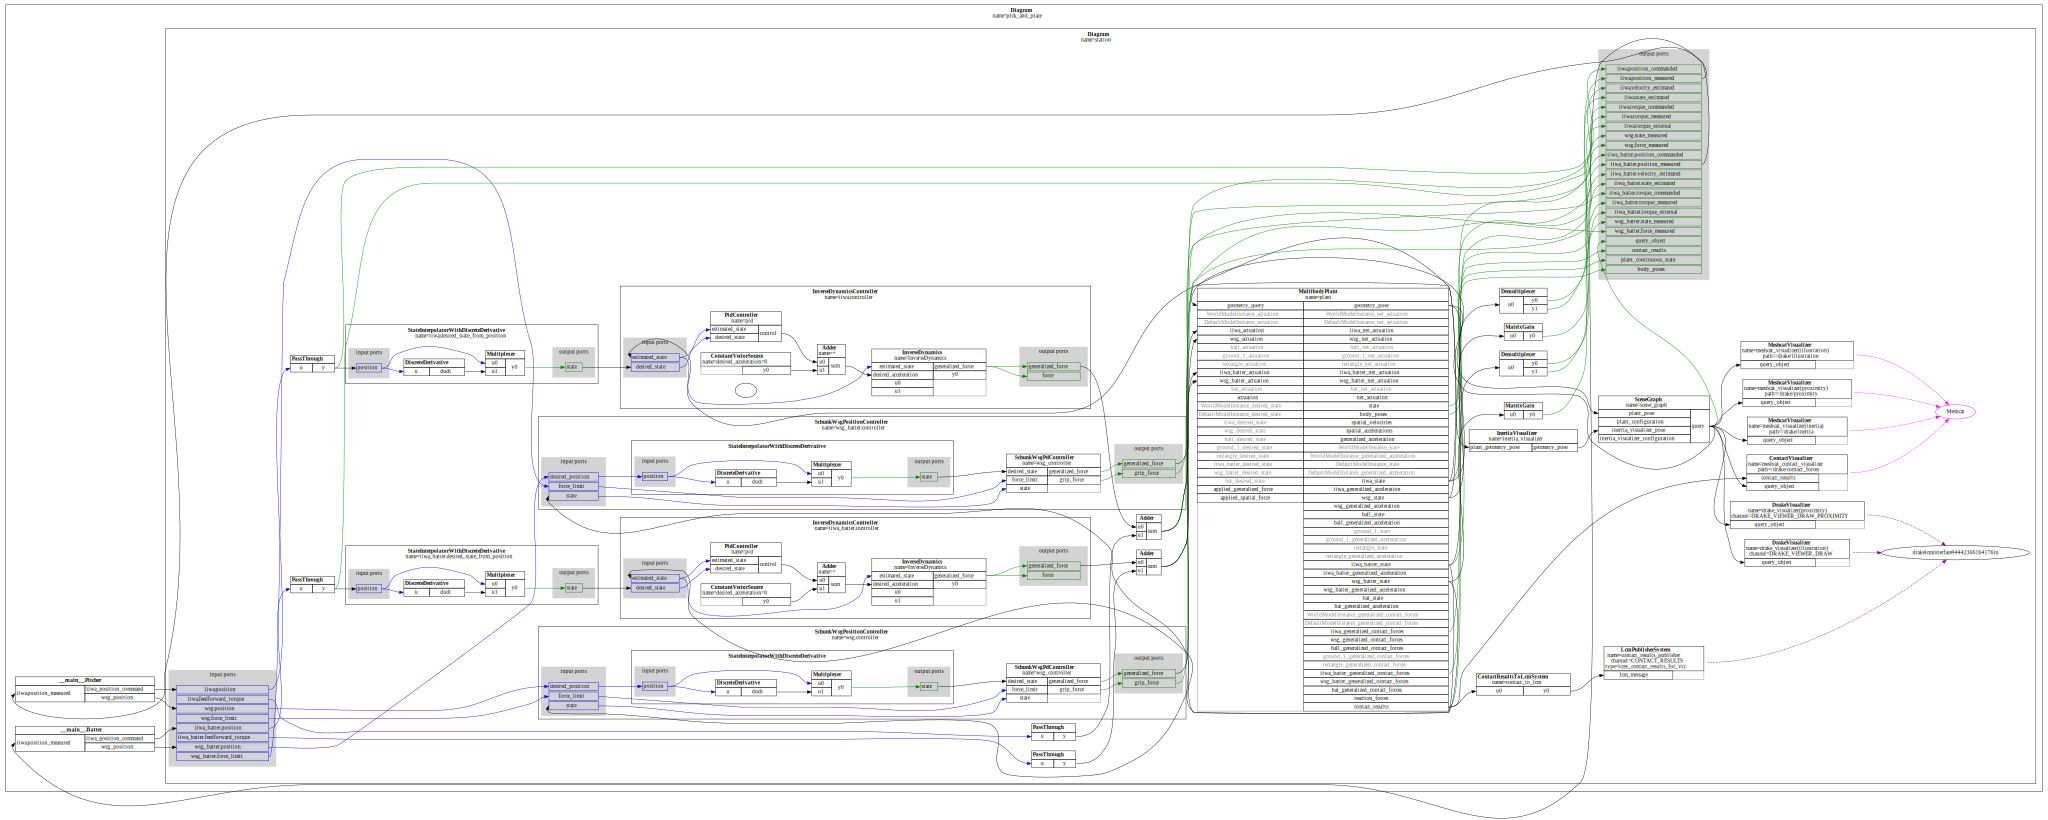

In [ ]:
from IPython.display import SVG
import pydot
display(
    SVG(
        pydot.graph_from_dot_data(diagram.GetGraphvizString())[
            0
        ].create_svg()
    )
)

In [ ]:
class Batter(LeafSystem):
    def __init__(self, plant, builder, plant_context):
        LeafSystem.__init__(self)
        self.builder = builder
        self.plant = plant
        
        self.q_port = self.DeclareVectorInputPort("iiwa.position_measured", 7)

        self.Gripper_X_Ball = G_X_B

        self.DeclareVectorOutputPort(
            "iiwa_position_command", 7, self.CalcIiwaPosition
        )
        self.DeclareVectorOutputPort(
            "wsg_position", 1, self.CalcWsgPosition
        )


        W_X_Binitial = plant.EvalBodyPoseInWorld(plant_context, plant.GetBodyByName("base_link"))
        W_X_Ginitial = plant.EvalBodyPoseInWorld(plant_context, plant.GetBodyByName("body", plant.GetModelInstanceByName('wsg')))

        self.Gripper_Frames, times = MakePickGripperFrames(W_X_Ginitial, W_X_Binitial, self.Gripper_X_Ball)

        q_start = controller_plant.GetPositions(controller_context)
        self.PickGripperPoseTrajectory = MakePickTrajectory(*MakeGripperPoseTrajectory(self.Gripper_Frames, times), q_start)
        self.PickGripperPositionTrajectory = MakeGripperCommandTrajectory(times)

        self.q_post_pick = self.PickGripperPoseTrajectory.value(self.PickGripperPoseTrajectory.end_time()).flatten()
        self.pick_end_time =  self.PickGripperPoseTrajectory.end_time()
        self.post_pick = False


        self.throw_start_time = self.pick_end_time

        self.W_p_Brelease, self.W_v_Brelease = DetermineInitialPositionAndVelocity(GOAL_PITCH)

        self.post_pick = False
        self.compute_throw_trajectory()
        # self.

    def CalcIiwaPosition(self, context, output):
        if context.get_time() > self.pick_end_time:
            output.set_value(self.ThrowJointTrajectory.value(context.get_time() - self.throw_start_time)[:7])
        else:
            output.set_value(self.PickGripperPoseTrajectory.value(context.get_time())[:7])

    def CalcWsgPosition(self, context, output):
        if context.get_time() > self.pick_end_time:
            output.set_value(self.ThrowGripperPositionTrajectory.value(context.get_time() - self.throw_start_time))
        else:
            output.set_value(self.PickGripperPositionTrajectory.value(context.get_time()))
    
    def compute_throw_trajectory(self):
        if self.post_pick: return
        W_X_Gstart = self.Gripper_Frames['goal']
        self.ThrowJointTrajectory = MakeThrowTrajectory(self.W_p_Brelease, self.W_v_Brelease, W_X_Gstart, self.Gripper_X_Ball,self.q_post_pick)
        self.ThrowGripperPositionTrajectory = MakeGripperThrowTrajectory(self.ThrowJointTrajectory)
        self.post_pick = True
        pass
        
        

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=51350a0a-d867-43ce-9cf7-7f2ad2ffd70b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>